# Computational astrophysics
# HW 4

In [1]:
# libraries imported 
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
%matplotlib widget
plt.style.use('/Users/dionysisgakis/.config/matplotlib/stylelib/publication.mplstyle') # plotting style, comment out if in another computer

## Problem 1

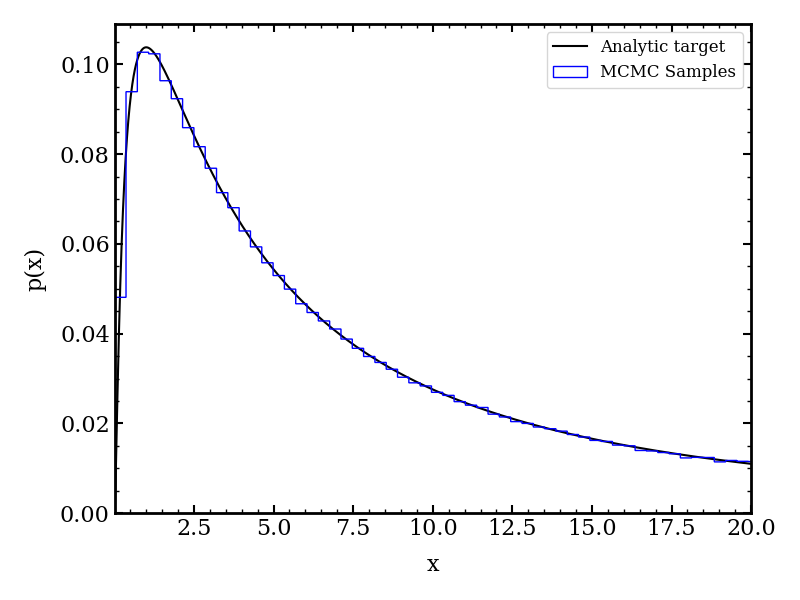

In [2]:
# target is Normal in log x, log x ~ N(2, 2)
# p(log x) = N(2, 2) = 1 / (sqrt(2 * pi * 2)) * exp(-0.5 * (log x - 2)^2 / 2)
# we need to find p(x) from p(log x)
# To do that we willl use the change of variables formula: p(x) = p(y) * |dy/dx|
# p(x) = p(log x) * |d(log x)/dx|
# So, p(x) = N(2, 2) * |d(log x)/dx| = N(2, 2) / x

np.random.seed(42)

def proposal_log(x):
    log_x = np.log(x)
    log_x_new = random.normal(log_x, 1)
    return np.exp(log_x_new)

def target_log(log_x, mean=2.0, variance=2.0):
    return -0.5 * (log_x - mean)**2 / variance - 0.5 * np.log(2 * np.pi * variance)

def acceptance_ratio_log(x, x_new):
    if x_new <= 0:
        return 0.0  # log(x) undefined
    log_x = np.log(x)
    log_x_new = np.log(x_new)
    lp = target_log(log_x)
    lp_new = target_log(log_x_new)
    return np.exp(lp_new - lp)

# MCMC sampler
def mcmc_sampler_log(x0, n_samples):
    samples = np.zeros(n_samples)
    samples[0] = x0
    for i in range(1, n_samples):
        x_new = proposal_log(samples[i - 1])
        r = random.uniform(0, 1)
        if acceptance_ratio_log(samples[i - 1], x_new) > r:
            samples[i] = x_new
        else:
            samples[i] = samples[i - 1]
    return samples

# Run the sampler
x0 = 1.0
n_samples = 1000000
samples = mcmc_sampler_log(x0, n_samples)

# Analytical target
x_vals = np.linspace(0.01, 20, 10000)
log_x_vals = np.log(x_vals)
target_transformed = np.exp(target_log(log_x_vals)) / x_vals 

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x_vals, target_transformed, label="Analytic target")
plt.hist(samples, bins=10000, density=True, histtype="step", label="MCMC Samples")
plt.xlim(x_vals.min(), x_vals.max())
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.tight_layout()
plt.show()


The output of the MCMC sampler changes from a normal distribution to log-normal. The samples are no longer symmetric around 2, but instead skewed right, with the peak near 1
and a long tail toward larger x. The new target distribution is:

$p(x) = \frac{p (\ln x)}{x} = \frac{1}{x} \frac{1}{\sqrt{4 \pi}} e^{-\frac{1}{2} \frac{(\ln x - 2)^2}{2}}$

## Problem 2

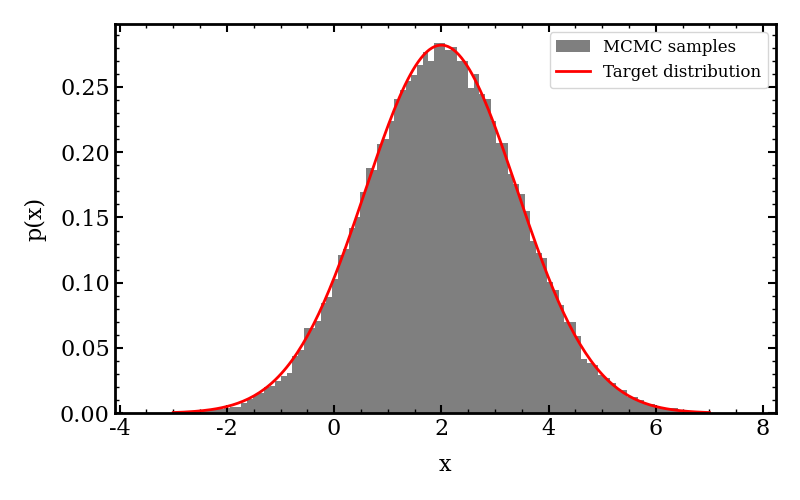

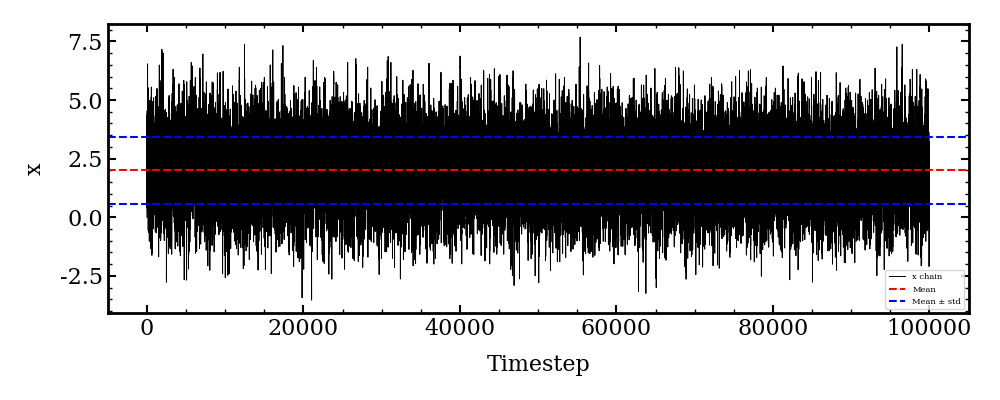

Segment	Mean		Variance
1	2.045		2.067
2	2.026		1.958
3	1.995		1.981
4	2.019		1.939


In [3]:
# Define target and proposal 

def proposal(x):
    return random.normal(x, 1)

def target(x):
    return np.exp(-(x - 2) ** 2 / 4) / np.sqrt(2 * np.pi * 2)

def acceptance_ratio(x, x_new):
    return np.exp((x - 2) ** 2 / 4 - (x_new - 2) ** 2 / 4)

# MCMC Sampler 
def mcmc_sampler(x0, n_samples):
    samples = np.zeros(n_samples)
    samples[0] = x0
    for i in range(1, n_samples):
        x_new = proposal(samples[i - 1])
        r = random.uniform(0, 1)
        if acceptance_ratio(samples[i - 1], x_new) > r:
            samples[i] = x_new
        else:
            samples[i] = samples[i - 1]
    return samples

x0 = 0
n_samples = 100000
samples = mcmc_sampler(x0, n_samples)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(samples, bins='scott', density=True, alpha=0.5, label='MCMC samples')
x_vals = np.linspace(-3, 7, 200)
plt.plot(x_vals, target(x_vals), color='red', lw=2, label='Target distribution')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()
plt.show()

# Plot x chain vs timestep
plt.figure(figsize=(10, 4))
plt.plot(samples[:], lw=0.7)
plt.xlabel("Timestep")
plt.ylabel("x")
plt.axhline(y=2, color='r', linestyle='--', lw=1.5)
plt.axhline(y=2 + np.sqrt(2), color='b', linestyle='--', lw=1.5)
plt.axhline(y=2 - np.sqrt(2), color='b', linestyle='--', lw=1.5)
plt.legend(['x chain', 'Mean', 'Mean ± std'], prop={'size': 6}) 
plt.show()

# Segment results
quarters = np.array_split(samples, 4)
print("Segment\tMean\t\tVariance")
for i, q in enumerate(quarters, 1):
    mean_q = np.mean(q)
    var_q = np.var(q)
    print(f"{i}\t{mean_q:.3f}\t\t{var_q:.3f}")


We notice that the empirical means and variances across the four segments are fairly consistent, and fairly close to the real values. Hence we conclude that the MCMC chain appears to have converged reasonably well. There is no strong trend across the segments, suggesting good sampling.

## Problem 3

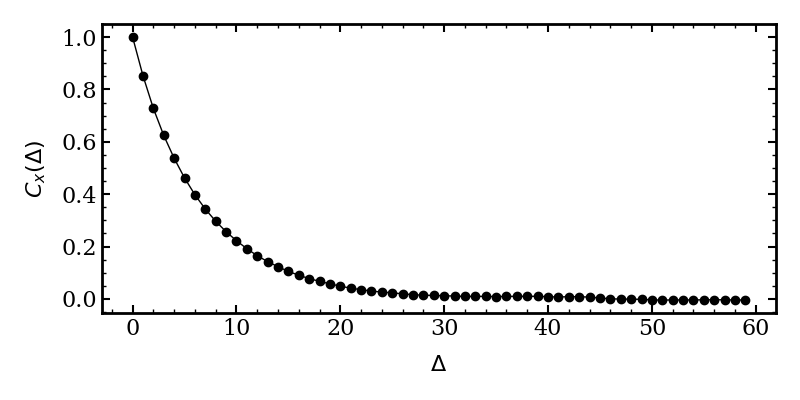

In [4]:
# autocorrelation is the convolution of the signal with itself
# but convolution in time domain is multiplication in frequency domain
# that's why we use FFT

# Convolution theorem: f*g=IFFT(FFT(f)⋅FFT(g))
# Steps:
# 1. Subtract the mean: x' = x - x̄
# 2. Compute FFT of x': F = FFT(x')
# 3. Power spectrum: |F|^2 = F * F*
# 4. Inverse FFT (unnormalized autocorrelation): acf = IFFT(|F|^2)
# 5. Normalize acf

# other things to consider
# 1. Zero-padding: FFT requires input length to be a power of 2
# 2. Circular convolution: FFT assumes periodicity, so we need to zero-pad
# 3. Normalization: divide by n - lag to account for decreasing number of terms

# This is the autocorrelation function:
# C_x(Δ) = 1/(n - Δ) ∑_(i=0)^(n - Δ - 1) (x_i - x̄)(x_(i + Δ) - x̄)

def autocorr_func_fft(x):
   
    x = np.asarray(x)
    n = len(x)
    x_mean = np.mean(x)
    x = x - x_mean

    # Pad with zeros (to avoid circular convolution) to reach power of 2 (FFT requires that)
    n_padded = 2 ** int(np.ceil(np.log2(2 * n - 1)))

    # FFT 
    f = np.fft.fft(x, n=n_padded)
    ps = np.abs(f)**2

    # Inverse FFT = unnormalized autocorrelation 
    acf = np.fft.ifft(ps).real[:n]
    acf /= np.arange(n, 0, -1)  # correct for decreasing number of terms

    # Normalize (C_x(0) = 1)
    acf /= acf[0]

    return acf

# Run on MCMC samples from previous problem
C_x = autocorr_func_fft(samples)

# Plot
plt.figure(figsize=(8, 4)) 
plt.plot(np.arange(60), C_x[:60], marker='o', lw=1) # lags Δ < 60
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$C_x(\Delta)$')
plt.show()


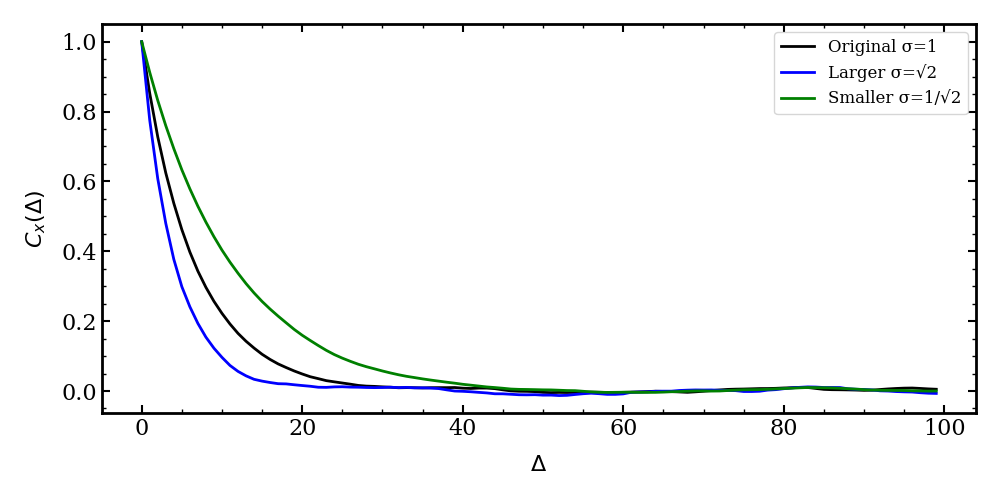

In [5]:
# with smaller and larger variance

def proposal_larger(x):
    return random.normal(x, np.sqrt(2))

def proposal_smaller(x):
    return random.normal(x, 1 / np.sqrt(2))

def mcmc_sampler(x0, n_samples, proposal):
    samples = np.zeros(n_samples)
    samples[0] = x0
    for i in range(1, n_samples):
        x_new = proposal(samples[i - 1])
        r = random.uniform(0, 1)
        if acceptance_ratio(samples[i - 1], x_new) > r:
            samples[i] = x_new
        else:
            samples[i] = samples[i - 1]
    return samples

samples_larger = mcmc_sampler(x0, n_samples, proposal=proposal_larger)
samples_smaller = mcmc_sampler(x0, n_samples, proposal=proposal_smaller)

C_larger = autocorr_func_fft(samples_larger)
C_smaller = autocorr_func_fft(samples_smaller)

plt.figure(figsize=(10, 5))
plt.plot(C_x[:100], label="Original σ=1", lw=2)
plt.plot(C_larger[:100], label="Larger σ=√2", lw=2)
plt.plot(C_smaller[:100], label="Smaller σ=1/√2", lw=2)
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$C_x(\Delta)$')
plt.legend()
plt.show()



The autocorrelation function drops fastest for the proposal with the largest step size, indicating better mixing. However, this comes at the cost of lower acceptance rate. Conversely, the smallest step size leads to slower decay in autocorrelation, reflecting poor mixing due to highly correlated samples. The moves are tiny, so the chain walks slowly through parameter space, resulting in strong correlation between samples. The original choice offers a balance between exploration and acceptance, resulting in moderate autocorrelation and efficient sampling.